In [49]:
import os
import sys
import glob
import linecache

import matplotlib as mt
from matplotlib import pylab
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from scipy import stats

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors

import nglview as nv

In [2]:
fred=pd.read_csv ('FRED_scores_zscores.csv')

In [3]:
vina= pd.read_csv ('vina_scores_zscores.csv')

In [4]:
vina_zscores=pd.DataFrame()
fred_zscores=pd.DataFrame()

In [5]:
vina_zscores['name']=vina['compound name']
vina_zscores['vina']=vina['Z_score']
fred_zscores['name']=fred['Title']
fred_zscores['fred']=fred['Z_Score']

In [6]:
zscores=pd.merge(vina_zscores,fred_zscores, on="name")

In [ ]:
zscores

## Getting the Gold  Scores from *.mol2 files

In [7]:
gold_folder='/home/angel/Desktop/Ordenar/results_gold/GOLD_ZND_results/'

In [8]:
os.chdir(gold_folder)
files=[]
scores=[]
for file in glob.glob("*.mol2"):
    try:
        with open(file,'rt') as f:
            modes=[]
            for i, line in enumerate(f):
                if 'Gold.Score' in line:
                    score=float(linecache.getline(file,i+3).strip().split(' ')[0])
                    modes.append (score)

            if max(modes) >=0:
                files.append (file.split('.')[0])
                scores.append(max(modes))
    except Exception:
        pass
d={ 'name':pd.Series(files),
    'score':pd.Series(scores)}
table=pd.DataFrame (d)
sort =table.sort_values ('score',ascending=False)
sort = sort.reset_index(drop=True)

In [9]:
n_score=[]
for score in sort['score']:
    n_score.append (score*-1)

In [10]:
g_zscore=stats.zscore (n_score)

In [11]:
sort['Z_score']=pd.Series(g_zscore)

In [12]:
sort.to_csv ('/home/angel/Documents/fabiola/DINAMICS/REVISION/prueba_OE/DOCKINGOE/screening/Gold_score.csv')

In [13]:
gold_zscores=pd.DataFrame()
gold_zscores['name']=sort['name']
gold_zscores['gold']=sort['Z_score']

In [14]:
zscores=pd.merge(zscores,gold_zscores, on="name")

### Getting the Rescore values of Gold.score from Gold *.mol2 files

In [16]:
os.chdir(gold_folder)
files=[]
scores=[]
for file in glob.glob("*.mol2"):
    try:
        with open(file,'rt') as f:
            modes=[]
            for i, line in enumerate(f):
                if 'Gold.Rescore' in line:
                    score=float(linecache.getline(file,i+3).strip().split(' ')[0])
                    modes.append (score)

            if max(modes) >=0:
                files.append (file.split('.')[0])
                scores.append(max(modes))
    except Exception:
        pass
d={ 'file':pd.Series(files),
    'score':pd.Series(scores)}
table=pd.DataFrame (d)
sort =table.sort_values ('score',ascending=False)
rescore = sort.reset_index(drop=True)

In [17]:
n_score=[]
for score in rescore['score']:
    n_score.append (score*-1)

In [18]:
gr_zscore=stats.zscore (n_score)

In [19]:
rescore['Z_score']=pd.Series(gr_zscore)

In [20]:
rescore.to_csv ('/home/angel/Documents/fabiola/DINAMICS/REVISION/prueba_OE/DOCKINGOE/screening/Gold_rescore.csv')

In [22]:
gold_rzscores=pd.DataFrame()
gold_rzscores['name']=rescore['file']
gold_rzscores['gold']=rescore['Z_score']

In [24]:
zscores=pd.merge(zscores,gold_rzscores, on="name")

In [26]:
zscores['zscore_concenso']=pd.Series (zscores.mean(axis=1)) 

In [27]:
sort_zscores =zscores.sort_values ('zscore_concenso',ascending=True)

In [28]:
sort_zscores=sort_zscores.reset_index(drop=True)

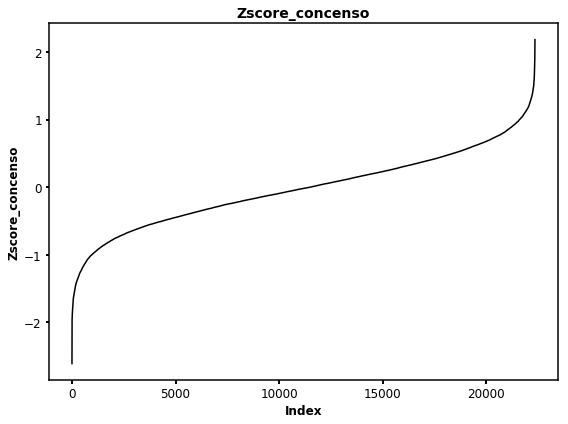

In [30]:
plt.rcParams['axes.linewidth'] = 1.5
plt.figure(figsize=(8,6))

plt.plot(list (sort_zscores['zscore_concenso']),color='k')
plt.title ('Zscore_concenso',fontsize=14,fontweight='bold',family='sans-serif')
plt.xlabel ('Index',fontsize=12,fontweight='bold')
plt.ylabel ('Zscore_concenso',fontsize=12,fontweight='bold')
plt.tick_params ('both',width=2,labelsize=12)
plt.tight_layout()
plt.show()

In [31]:
h=list(sort_zscores ['zscore_concenso'])
h.sort()
hmean = np.mean(h)
hstd = np.std(h)

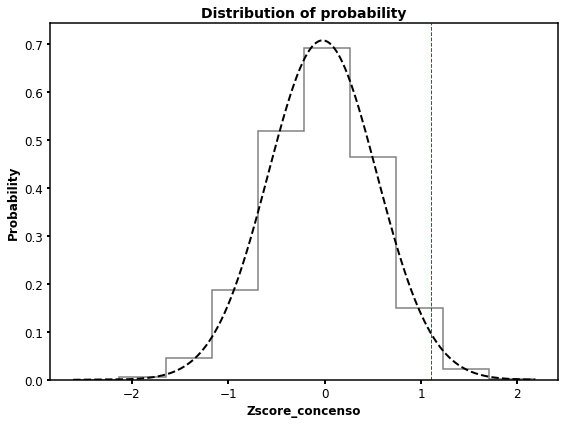

In [32]:
plt.rcParams['axes.linewidth'] = 1.5
pdf = stats.norm.pdf(h, hmean, hstd)
plt.figure(figsize=(8,6))

plt.plot(h,pdf,'k--',linewidth=2.0)
plt.hist(h,density=True,histtype='step',color='gray',linewidth=1.5)
plt.title ('Distribution of probability',fontsize=14,fontweight='bold',family='sans-serif')
plt.xlabel ('Zscore_concenso',fontsize=12,fontweight='bold')
plt.ylabel ('Probability',fontsize=12,fontweight='bold')
plt.tick_params ('both',width=2,labelsize=12)
plt.axvline(x=hmean+(2*hstd),color='r',linewidth=1,linestyle='--',)
plt.tight_layout()
plt.show()

In [33]:
heavy_atoms=[]
molecules=Chem.SDMolSupplier ('/home/angel/Documents/fabiola/DINAMICS/REVISION/sdf_znd/109_p0.0.sdf')
for mol in molecules:
    if mol.GetProp('_Name') in list(sort_zscores['name']):
        heavy_atoms.append (mol.GetNumHeavyAtoms())

In [34]:
sort_zscores['heavy_atoms']=pd.Series(heavy_atoms)

In [35]:
rescoring=[]
for i in range(len(sort_zscores['name'])):
    rescoring.append (sort_zscores.loc[i].at['zscore_concenso']/sort_zscores.loc[i].at['heavy_atoms'])

In [36]:
sort_zscores['rescoring']=pd.Series(rescoring)

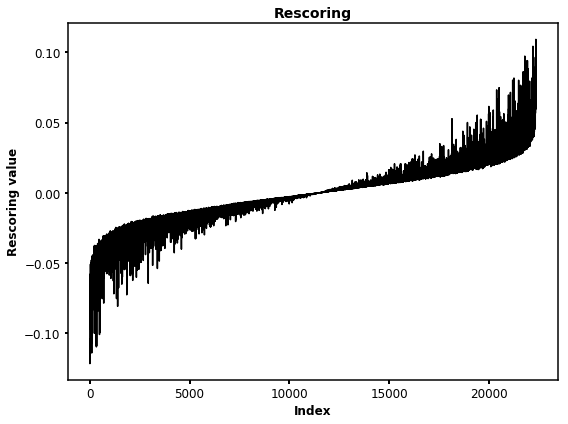

In [55]:
plt.rcParams['axes.linewidth'] = 1.5
plt.figure(figsize=(8,6))

plt.plot(list (sort_zscores['rescoring']),color='k')
plt.title ('Rescoring',fontsize=14,fontweight='bold',family='sans-serif')
plt.xlabel ('Index',fontsize=12,fontweight='bold')
plt.ylabel ('Rescoring value',fontsize=12,fontweight='bold')
plt.tick_params ('both',width=2,labelsize=12)
plt.tight_layout()
plt.show()

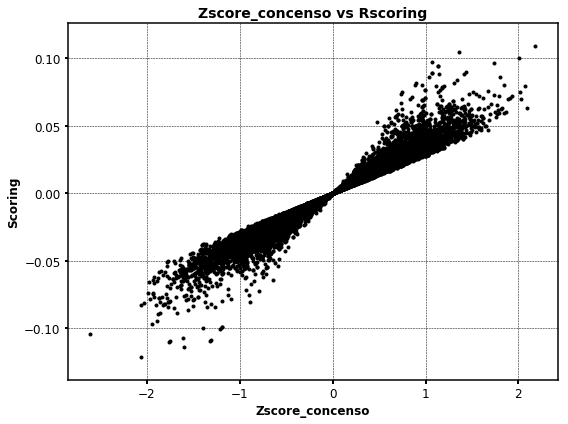

In [38]:
plt.rcParams['axes.linewidth'] = 1.5
plt.figure(figsize=(8,6))

plt.scatter (sort_zscores['zscore_concenso'],sort_zscores['rescoring'],color='k',marker='.')
plt.title ('Zscore_concenso vs Rscoring',fontsize=14,fontweight='bold',family='sans-serif')
plt.xlabel ('Zscore_concenso',fontsize=12,fontweight='bold')
plt.ylabel ('Scoring',fontsize=12,fontweight='bold')
plt.tick_params ('both',width=2,labelsize=12)
plt.grid (linestyle='--', linewidth=0.5,color='k')
plt.tight_layout()
plt.show()

In [39]:
bob=[]
for i in range(len(sort_zscores['name'])):
    if sort_zscores.loc[i].at['zscore_concenso'] <=-1.8 and sort_zscores.loc[i].at['rescoring']<= -0.075:
        bob.append (sort_zscores.loc[i].at['name'])

In [40]:
mols=[]
for mol in molecules:
    if mol.GetProp('_Name') in bob:
        mols.append(mol)

In [41]:
from rdkit.Chem import rdFMCS
res=rdFMCS.FindMCS(mols)

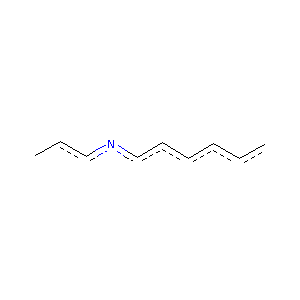

In [42]:
Draw.MolToImage (Chem.MolFromSmarts(res.smartsString))

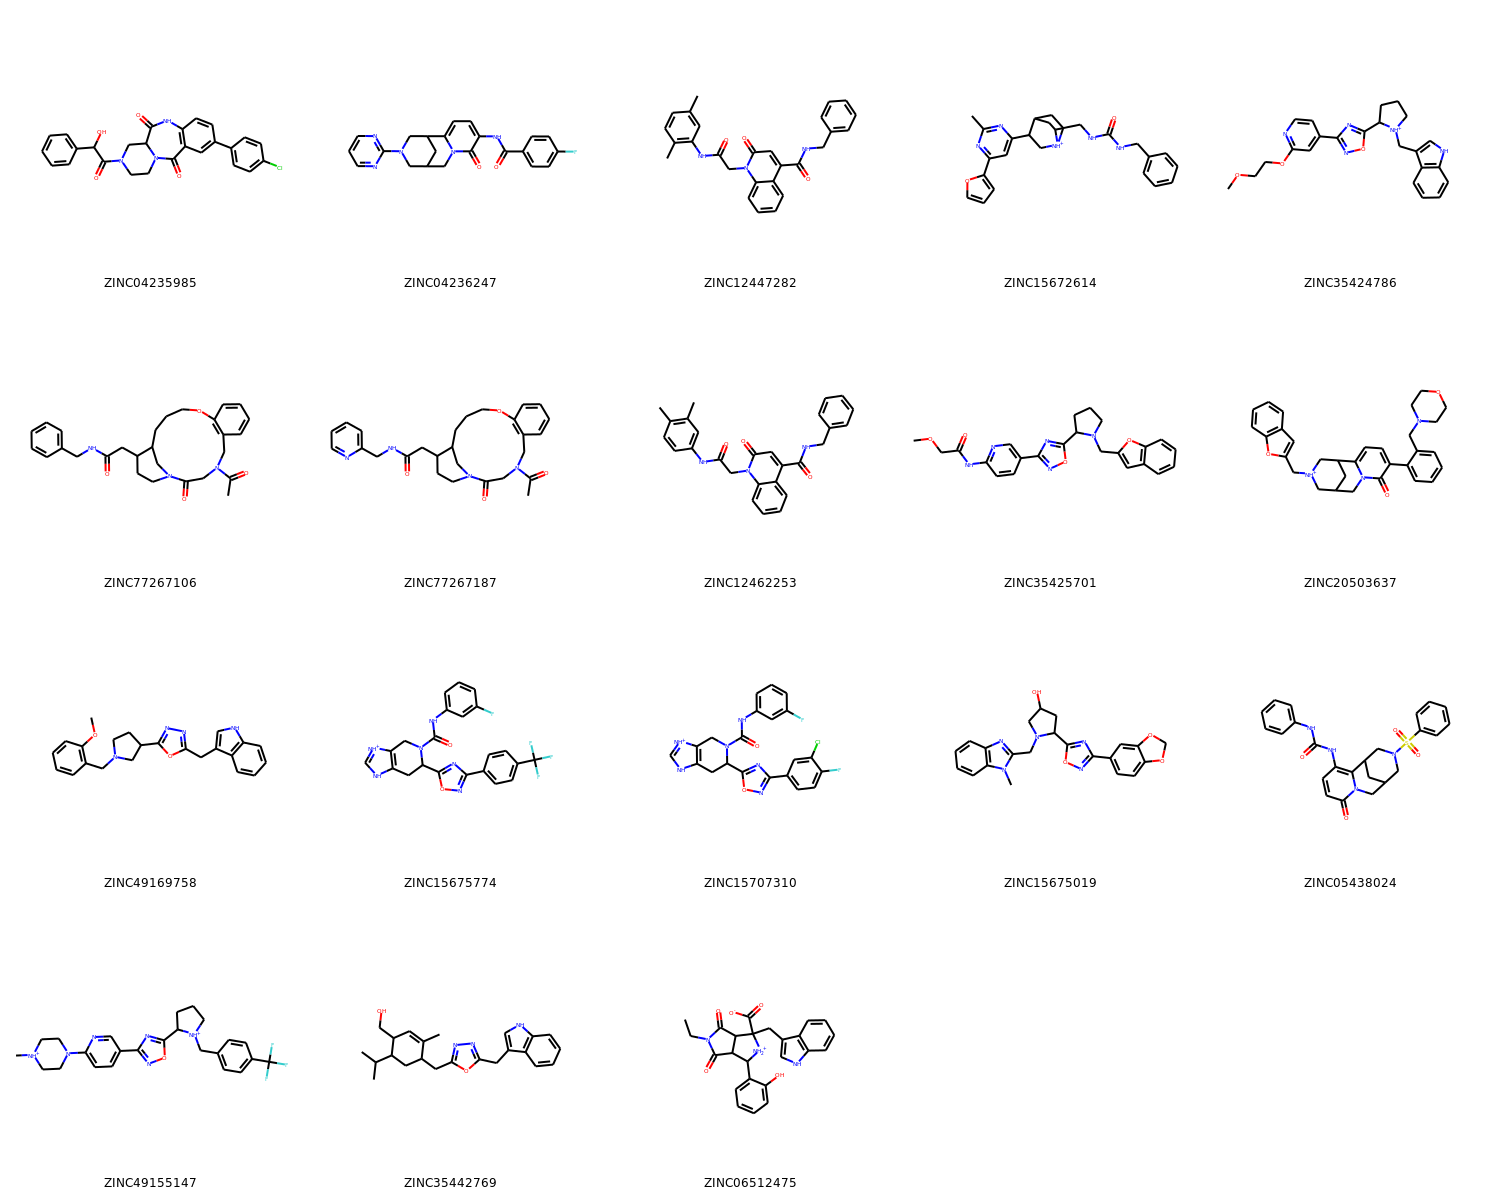

In [43]:
[mol.Compute2DCoords() for mol in mols]
Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(300,300),legends=[mol.GetProp("_Name") for mol in mols])

In [44]:
len (mols)

18

In [52]:
[(mol.GetProp('_Name'),Descriptors.MolWt(mol)) for mol in mols]

[('ZINC04235985', 475.9320000000002),
 ('ZINC04236247', 405.4330000000001),
 ('ZINC12447282', 439.5150000000002),
 ('ZINC15672614', 432.54800000000006),
 ('ZINC35424786', 420.49300000000017),
 ('ZINC77267106', 477.6050000000003),
 ('ZINC77267187', 478.5930000000003),
 ('ZINC12462253', 439.5150000000002),
 ('ZINC35425701', 433.4680000000003),
 ('ZINC20503637', 496.63100000000037),
 ('ZINC49169758', 388.47100000000006),
 ('ZINC15675774', 473.41000000000014),
 ('ZINC15707310', 457.8480000000001),
 ('ZINC15675019', 419.44100000000014),
 ('ZINC05438024', 464.5470000000002),
 ('ZINC49155147', 474.53100000000023),
 ('ZINC35442769', 379.5040000000001),
 ('ZINC06512475', 433.4640000000001)]

In [45]:
sort_zscores.to_csv ('/home/angel/Documents/fabiola/DINAMICS/REVISION/prueba_OE/DOCKINGOE/screening/zscores.csv')

for tar in targets:
    print (tar)
    cmd.load (l_folder+tar+'.mol2',object='lig',state=0,finish=1)
    cmd.select ('dummy', 'not name C,H,O,N,P,S')
    cmd.remove('dummy')
    cmd.load (p_folder+tar.split('_')[0]+'.mol2',object='prot')
    cmd.select ('enabled')
    cmd.save(filename=c_folder+tar+'.pdb',selection='sele', state=-1,format='pdb')
    cmd.deselect()
    cmd.delete('all')

In [53]:
out_mols=Chem.SDWriter ('/home/angel/Desktop/candidates.sdf')

In [54]:
for mol in mols:
    out_mols.write(mol)
out_mols.close()